# 0. Import library


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import seaborn as sns
import warnings
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. Data Analyzing
🌱 [참고 자료](https://www.kaggle.com/competitions/severstal-steel-defect-detection)

In [ ]:
# 코랩에서 구글 드라이브 접근
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/"

In [ ]:
# 데이터 불러오기
train_df = pd.read_csv(path+"new_train.csv") # multi label 제거

In [ ]:
# 데이터셋 전체 출력을 위한 옵션
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [ ]:
train_df

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
6234,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
6235,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
6236,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
6237,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [ ]:
# class id에 따른 손상의 종류 개수 파악하기
defect1_count = train_df[train_df['ClassId']==1]['EncodedPixels'].notnull().count()
defect2_count = train_df[train_df['ClassId']==2]['EncodedPixels'].notnull().count()
defect3_count = train_df[train_df['ClassId']==3]['EncodedPixels'].notnull().count()
defect4_count = train_df[train_df['ClassId']==4]['EncodedPixels'].notnull().count()
defect1_count, defect2_count, defect3_count, defect4_count

(769, 195, 4759, 516)

<Axes: >

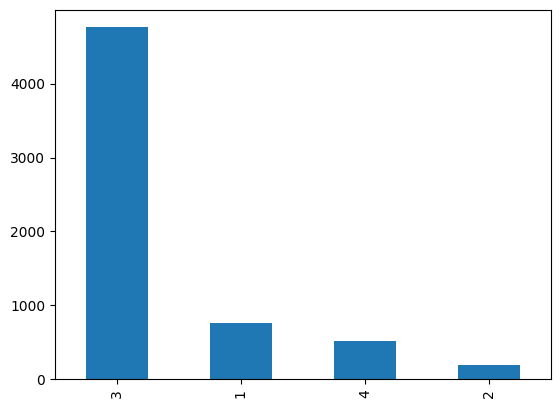

In [ ]:
train_df["ClassId"].value_counts().plot(kind = 'bar')

Text(0.5, 1.0, 'Defect Type Ratio')

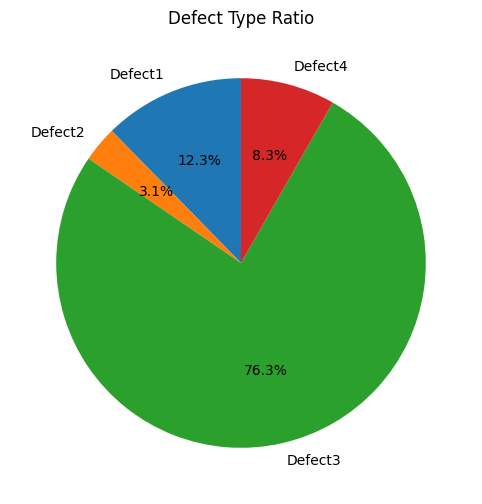

In [ ]:
# 클래스별 개수 이미지로 한눈에 보기
labels = ['Defect1', "Defect2", "Defect3", "Defect4"]
size_data = [defect1_count, defect2_count, defect3_count, defect4_count]
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
options = ax.pie(size_data, labels=labels,autopct="%1.1f%%", startangle=90)
ax.set_title("Defect Type Ratio")

# 2. Data preprocessing

Image Augmentation

In [ ]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(train_df.values):
    image=cv2.imread(path+"train_images/{}".format(img),cv2.IMREAD_COLOR)
    image = cv2.resize(image, (200,32)) # original image = (1600, 256) -> 크기 줄임
    if ClassId in [1, 4, 2]:
        l1.append(image)
        l2.append(ClassId)

        # Horizontally flip the image
        flipped_image_h = cv2.flip(image, 1)  # 1 means flip horizontally
        l1.append(flipped_image_h)
        l2.append(ClassId)

        # Vertically flip the image
        flipped_image_v = cv2.flip(image, 0)  # 0 means flip vertically
        l1.append(flipped_image_v)
        l2.append(ClassId)

    else:
        l1.append(image)
        l2.append(ClassId)


100%|██████████| 6239/6239 [00:53<00:00, 115.64it/s]


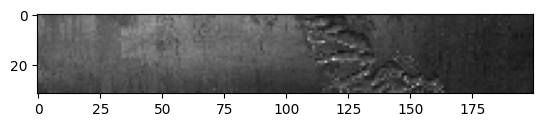

In [ ]:
plt.imshow(l1[16])

Label encoding the input features and one hot encoding the target feature.

In [ ]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = to_categorical(y)

Splitting the data into 80% train set and 10% validation set and 10% test set

In [ ]:
# 전체 데이터셋을 train과 나머지로 나누기
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

# 나머지를 다시 나눠서 validation과 test로 나누기
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, shuffle=True)

Splitting the data into 80% train set and 20% test set

In [ ]:
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [ ]:
# print("x_train shape:",X_train.shape)
# print("x_test shape:",X_test.shape)
# print("y_train shape:",y_train.shape)
# print("y_test shape:",y_test.shape)

# 3. CNN


[참고 자료](https://www.kaggle.com/code/ratul6/steel-defect-detection-using-cnn) <br>

Building the CNN Model

In [ ]:
img_shape = (32, 200, 3)
# Set up the model
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3), strides=(1, 1), padding="same", activation="relu",input_shape=img_shape))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))
# model.summary()

In [ ]:
early_stopping = EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)
# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/졸업과제/모델/CNN/modelV3.h5", monitor="val_accuracy", save_best_only=True, mode="max")
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [ ]:
# Initialize lists to store metrics for each epoch
train_acc_list = []
train_loss_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []
train_roc_auc_list = []

val_acc_list = []
val_loss_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []
val_roc_auc_list = []

# Train the model
for epoch in range(50):
    history = model.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val), batch_size=128,
                        verbose=1, callbacks=[early_stopping,  model_checkpoint])

    train_loss_list.append(history.history['loss'][0])
    val_loss_list.append(history.history['val_loss'][0])
    # Predictions on training and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to categorical labels
    y_train_labels = np.argmax(y_train, axis=1)
    y_val_labels = np.argmax(y_val, axis=1)

    # Evaluate metrics on training set
    train_accuracy = accuracy_score(y_train_labels, np.argmax(y_train_pred, axis=1))
    train_precision = precision_score(y_train_labels, np.argmax(y_train_pred, axis=1), average="weighted")
    train_recall = recall_score(y_train_labels, np.argmax(y_train_pred, axis=1), average="weighted")
    train_f1 = f1_score(y_train_labels, np.argmax(y_train_pred, axis=1), average="weighted")
    train_roc_auc = roc_auc_score(y_train, y_train_pred, average="macro", multi_class="ovr")
    # Evaluate metrics on validation set
    val_accuracy = accuracy_score(y_val_labels, np.argmax(y_val_pred, axis=1))
    val_precision = precision_score(y_val_labels, np.argmax(y_val_pred, axis=1), average="weighted")
    val_recall = recall_score(y_val_labels, np.argmax(y_val_pred, axis=1), average="weighted")
    val_f1 = f1_score(y_val_labels, np.argmax(y_val_pred, axis=1), average="weighted")
    val_roc_auc = roc_auc_score(y_val, y_val_pred, average="macro", multi_class="ovr")

    # Append metrics to lists
    train_acc_list.append(train_accuracy)
    train_precision_list.append(train_precision)
    train_recall_list.append(train_recall)
    train_f1_list.append(train_f1)
    train_roc_auc_list.append(train_roc_auc)

    val_acc_list.append(val_accuracy)
    val_precision_list.append(val_precision)
    val_recall_list.append(val_recall)
    val_f1_list.append(val_f1)
    val_roc_auc_list.append(val_roc_auc)

58/58 [==============================] - ETA: 0s - loss: 1.0967 - accuracy: 0.5207

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 25s 437ms/step - loss: 0.8477 - accuracy: 0.6264 - val_loss: 0.7297 - val_accuracy: 0.6870


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - ETA: 0s - loss: 0.7171 - accuracy: 0.6815

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - ETA: 0s - loss: 0.6377 - accuracy: 0.7227

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 26s 448ms/step - loss: 0.6006 - accuracy: 0.7373 - val_loss: 0.5884 - val_accuracy: 0.7652


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.7592

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - ETA: 0s - loss: 0.4652 - accuracy: 0.8115

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - ETA: 0s - loss: 0.4396 - accuracy: 0.8199

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - ETA: 0s - loss: 0.3677 - accuracy: 0.8483

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.8728

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8780

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9228

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9503

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9649

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9701

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 1s 28ms/step


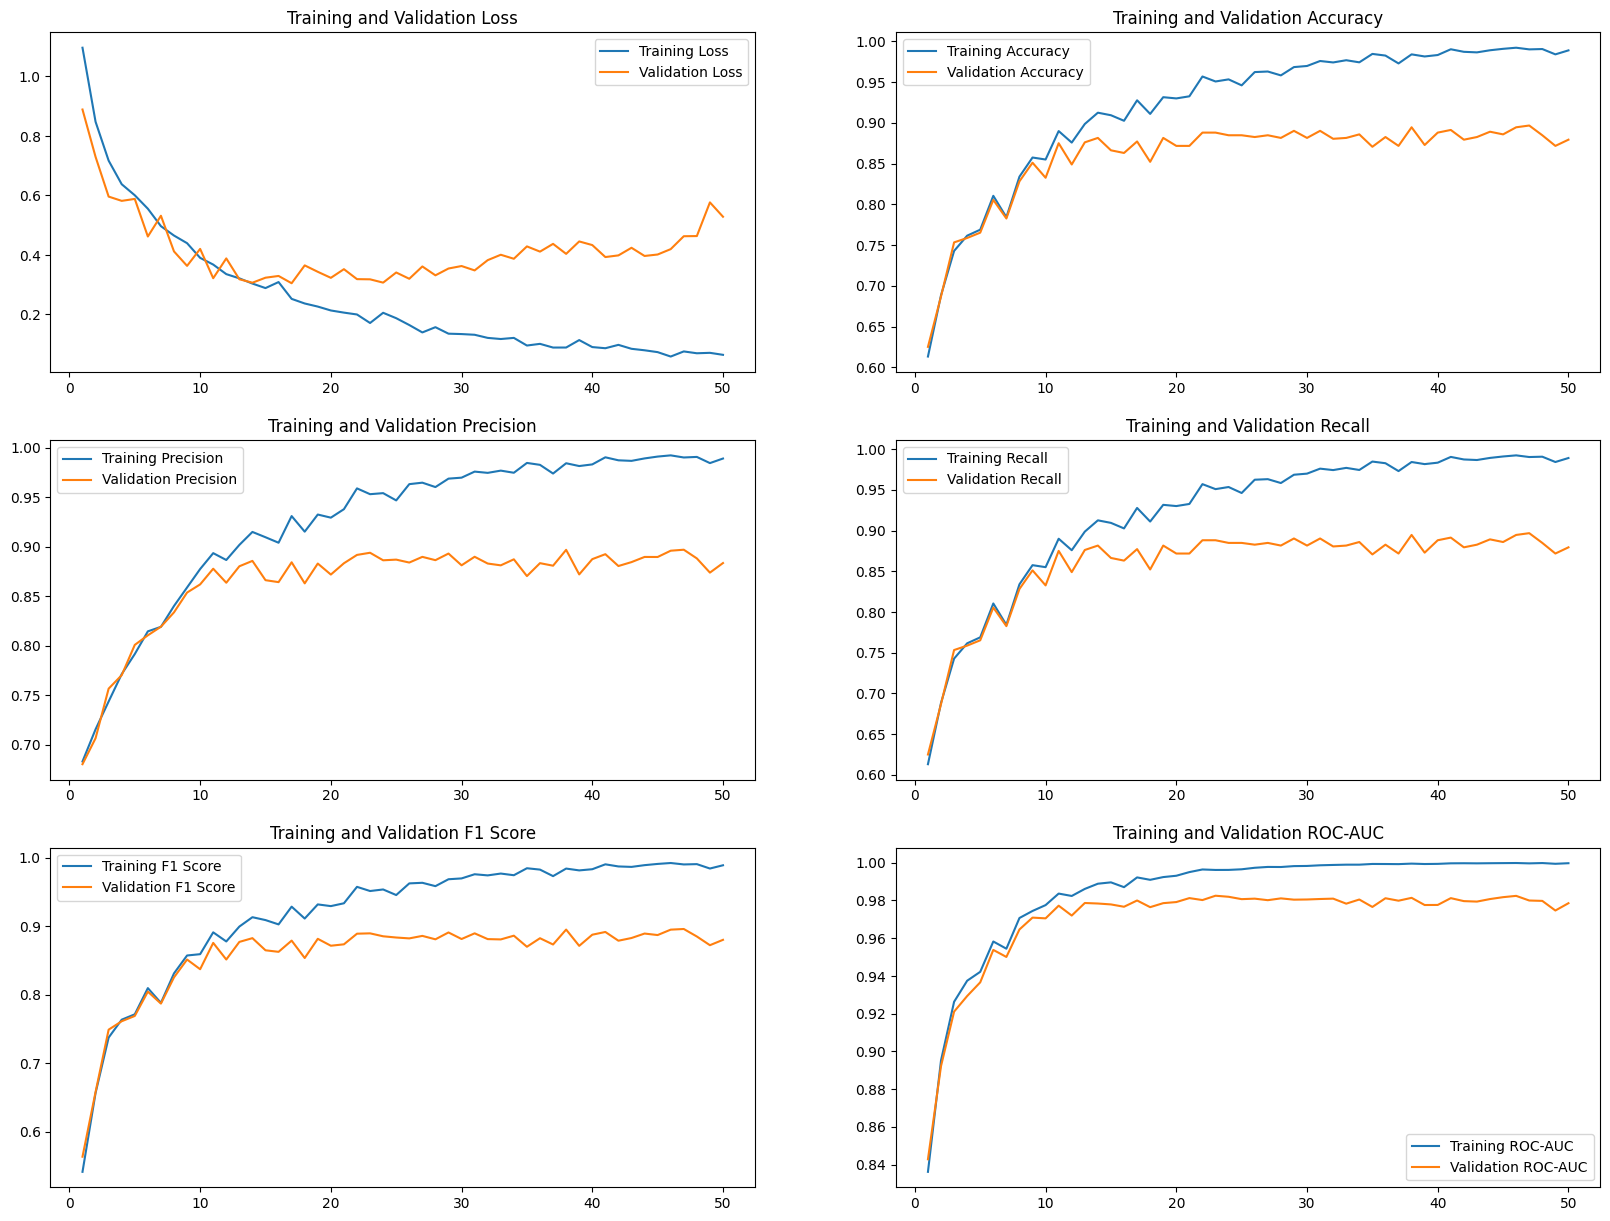

In [ ]:
# Plot the metrics
epochs_range = range(1, len(train_acc_list) + 1)

plt.figure(figsize=(20, 15))

plt.subplot(3, 2, 1)
plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, val_loss_list, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(3, 2, 2)
plt.plot(epochs_range, train_acc_list, label='Training Accuracy')
plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(3, 2, 3)
plt.plot(epochs_range, train_precision_list, label='Training Precision')
plt.plot(epochs_range, val_precision_list, label='Validation Precision')
plt.legend()
plt.title('Training and Validation Precision')

plt.subplot(3, 2, 4)
plt.plot(epochs_range, train_recall_list, label='Training Recall')
plt.plot(epochs_range, val_recall_list, label='Validation Recall')
plt.legend()
plt.title('Training and Validation Recall')

plt.subplot(3, 2, 5)
plt.plot(epochs_range, train_f1_list, label='Training F1 Score')
plt.plot(epochs_range, val_f1_list, label='Validation F1 Score')
plt.legend()
plt.title('Training and Validation F1 Score')

plt.subplot(3, 2, 6)
plt.plot(epochs_range, train_roc_auc_list, label='Training ROC-AUC')
plt.plot(epochs_range, val_roc_auc_list, label='Validation ROC-AUC')
plt.legend()
plt.title('Training and Validation ROC-AUC')

plt.show()

In [ ]:
y_test_pred = model.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)

29/29 [==============================] - 1s 25ms/step


In [ ]:
test_targets = y_test_labels
test_preds = np.argmax(y_test_pred, axis=1)

In [ ]:
test_accuracy = accuracy_score(y_test_labels, np.argmax(y_test_pred, axis=1))
test_precision = precision_score(y_test_labels, np.argmax(y_test_pred, axis=1), average="weighted")
test_recall = recall_score(y_test_labels, np.argmax(y_test_pred, axis=1), average="weighted")
test_f1 = f1_score(y_test_labels, np.argmax(y_test_pred, axis=1), average="weighted")
test_roc_auc = roc_auc_score(y_test, y_test_pred, average="macro", multi_class="ovr")
print("accuracy", test_accuracy)
print("precision", test_precision)
print("recall", test_recall)
print("f1", test_f1)
print("roc_auc", test_roc_auc)

accuracy 0.8880434782608696
precision 0.8915187296672912
recall 0.8880434782608696
f1 0.888022296463762
roc_auc 0.9791798329068004


In [ ]:
real = []
for i in test_targets:
  real.append(i)
pred = []
for i in test_preds:
  pred.append(i)

Accuracy: 0.8880434782608696
Label: 1
Accuracy,  0.9380434782608695
Precision: 0.8878923766816144
Recall: 0.8608695652173913
F1 Score: 0.8741721854304637
[[198  25]
 [ 32 665]]


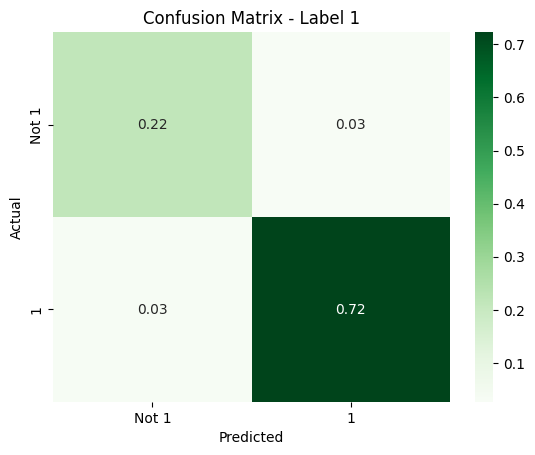

Label: 2
Accuracy,  0.9793478260869565
Precision: 0.9347826086956522
Recall: 0.7288135593220338
F1 Score: 0.819047619047619
[[ 43   3]
 [ 16 858]]


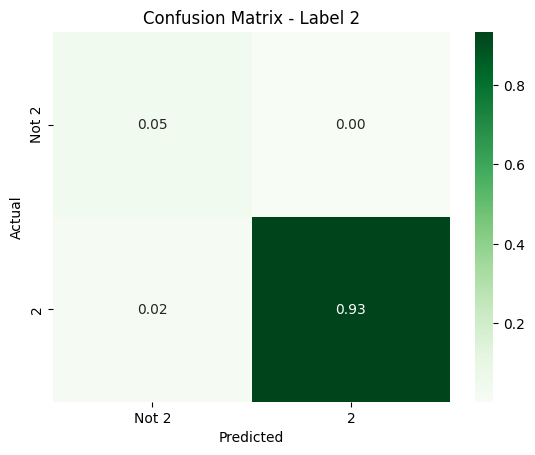

Label: 3
Accuracy,  0.9108695652173913
Precision: 0.9191489361702128
Recall: 0.907563025210084
F1 Score: 0.9133192389006344
[[432  38]
 [ 44 406]]


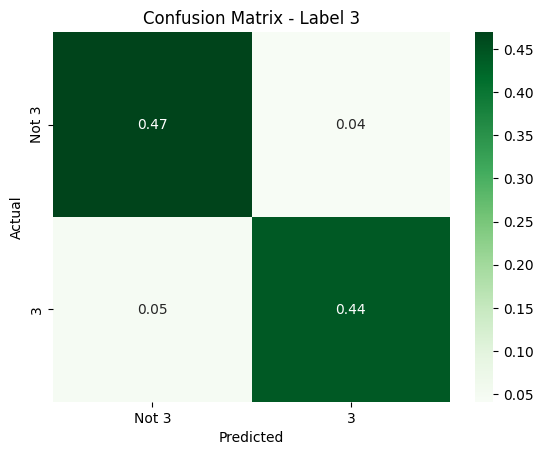

Label: 4
Accuracy,  0.9478260869565217
Precision: 0.7955801104972375
Recall: 0.9290322580645162
F1 Score: 0.8571428571428572
[[144  37]
 [ 11 728]]


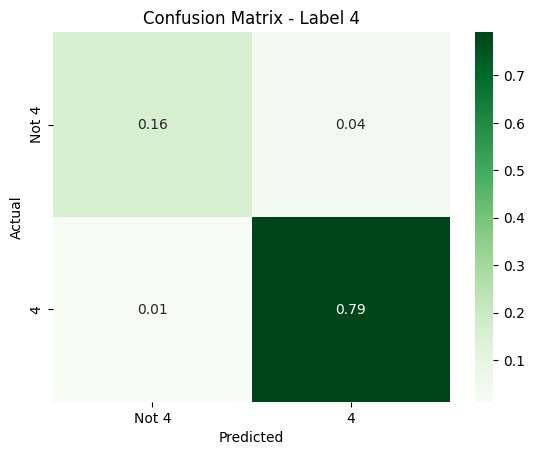

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


labels = [0 ,1 ,2 ,3]

accuracy = accuracy_score(real,pred)
print("Accuracy:", accuracy)

for label in labels:
    # True Positive (TP): 실제값과 예측값이 모두 해당 레이블인 경우
    tp = sum([r == label and p == label for r,p in zip(real,pred)])

    # False Positive (FP): 실제값은 해당 레이블이 아니지만 예측값은 해당 레이블인 경우
    fp = sum([r != label and p == label for r,p in zip(real,pred)])

    # False Negative (FN): 실제값은 해당 레이블인데 예측값은 해당 레이블이 아닌 경우
    fn = sum([r == label and p != label for r,p in zip(real,pred)])

    # True Negative (TN): 실제값과 예측값 모두 해당 레이블이 아닌 경우
    tn = sum([r != label and p != label for r, p in zip(real, pred)])

    # Accuracy: (TP + TN) / (TP + TN + FP + FN)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Precision: TP / (TP + FP)
    precision = tp / (tp + fp)

    # Recall: TP / (TP + FN)
    recall = tp / (tp + fn)

    # F1 Score: Harmonic mean of Precision and Recall
    f1score = 2 * ((precision * recall) / (precision + recall))

    print("Label:",label+1)
    print("Accuracy, ", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1score)

    matrix = np.array([[tp, fp], [fn, tn]])
    print(matrix)
    # Create a heatmap using seaborn
    ax = sns.heatmap(matrix / np.sum(matrix), annot=True,
                     fmt=".2f", cmap="Greens",
                     xticklabels=['Not '+str(label+1), str(label+1)],
                     yticklabels=['Not '+str(label+1), str(label+1)])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    title = f"Confusion Matrix - Label {label+1}"
    plt.title(title)
     # Show the plot
    plt.show()



In [ ]:
# Confusion matrix
cm = confusion_matrix(test_targets, test_preds)
print("Confusion matrix:")
print(cm)

Confusion matrix:
[[198   2  24   6]
 [ 11  43   5   0]
 [ 12   1 432  31]
 [  2   0   9 144]]


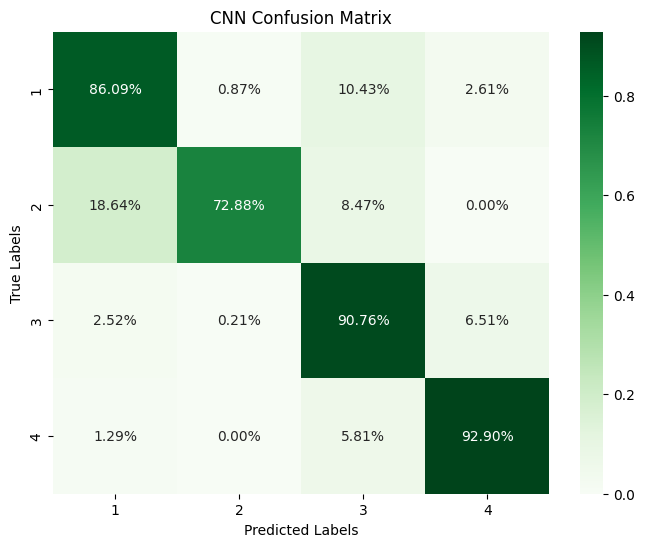

In [ ]:
# Calculate proportions
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Greens", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

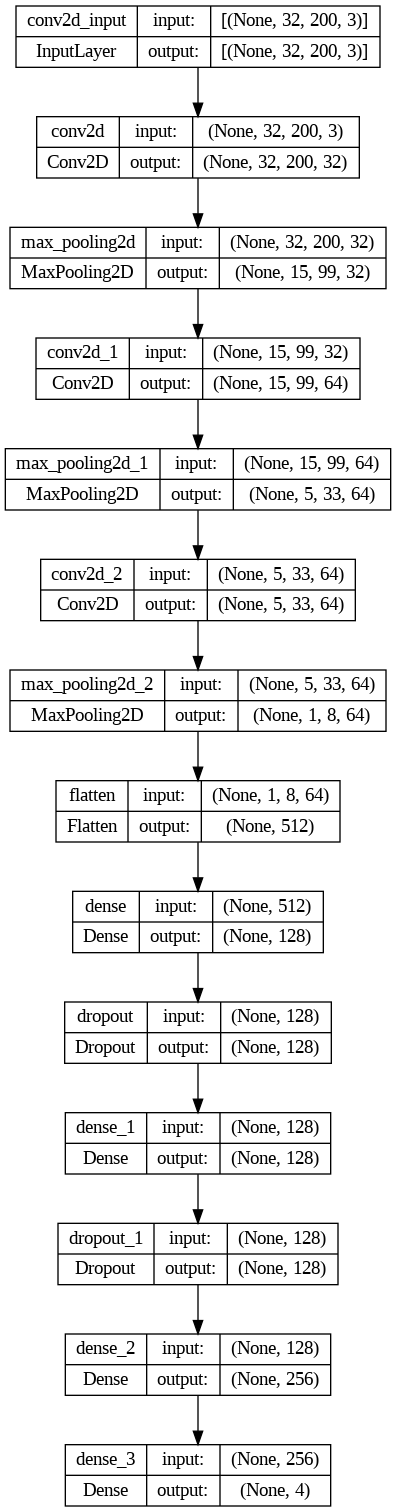

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.load_weights("/content/drive/MyDrive/졸업과제/모델/CNN/modelV2.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("/content/drive/MyDrive/졸업과제/모델/CNN/modelV2.h5")